# Open TEM data files with pyNSID

A fast  introduction to an easy to use but comprehensive data format.

pyNSID is based on pyUSID and part of pycroscopy 

pyNSID has two forms. 
- a front end that is based on dask
- a back end to store the data in an hdf5 dataset

First we load the usual suspects

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab --no-import-all notebook 

# import pyNSID (the basic way at this point)
import os, sys
sys.path.append('../../')
import pyNSID as nsid

import file_tools_nsid as ft

Populating the interactive namespace from numpy and matplotlib
windows


## Load data 
We load a data file and get a dictionary 

In [2]:
filename = ft.openfile_dialog()
path, file_name = os.path.split(filename)
basename, extension = os.path.splitext(file_name)
tags = ft.open_file(filename)  

not_instance


## Make an NSID Dataset out of it:


In [4]:
def make_dask_dataset(tags):
    tags_dimension, main_data = ft.get_dimension_tags(tags)
    data = nsid.NSIDask.from_array(main_data)
    for index, dimension in tags_dimension.items():
        data.set_dimension(index, dimension)
        
    data.quantity = 'intensity'
    data.units="counts"
    data.data_type = tags['data_type']
    data.modality = 'STEM/TEM'
    if 'spectrum' in data.data_type:
        if 'EDS'  in  data.data_type:
            data.source= 'EDS'
        else:
            data.source= 'EELS'
    else:
        data.source= 'detector'
    
    
    data.original_metadata = ft.flatten_directory(tags['original_metadata'])

    if 'aberrations' in tags:
        #set_attribute('aberrations')
        data.aberrations =  tags['aberrations']
    if 'annotations' in tags:
        data.annotations =  tags['annotations']

    if 'image' in tags:
        data.attrs.update(tags['image'])

    for key, value in tags.items():
        if isinstance(value,dict):
            pass
        elif 'data' == key:
            pass
        else:
            data.attrs[key]= value
            
    return data


In [3]:
data = ft.make_dask_dataset(tags)

0
1
2


We can now access these additional dimensional information

In [4]:
print(data.x)
print('units of y-axis :',data.y.units)
print('quantity of x-axis :',data.x.quantity)
print('values of y-axis :',data.y.values)


x - distance (nm): [ 0.       0.03125  0.0625   0.09375  0.125    0.15625  0.1875   0.21875
  0.25     0.28125  0.3125   0.34375  0.375    0.40625  0.4375   0.46875
  0.5      0.53125  0.5625   0.59375  0.625    0.65625  0.6875   0.71875
  0.75     0.78125  0.8125   0.84375  0.875    0.90625  0.9375   0.96875
  1.       1.03125  1.0625   1.09375  1.125    1.15625  1.1875   1.21875
  1.25     1.28125  1.3125   1.34375  1.375    1.40625  1.4375   1.46875
  1.5      1.53125  1.5625   1.59375  1.625    1.65625  1.6875   1.71875
  1.75     1.78125  1.8125   1.84375  1.875    1.90625  1.9375   1.96875
  2.       2.03125  2.0625   2.09375  2.125    2.15625  2.1875   2.21875
  2.25     2.28125  2.3125   2.34375  2.375    2.40625  2.4375   2.46875
  2.5      2.53125  2.5625   2.59375  2.625    2.65625  2.6875   2.71875
  2.75     2.78125  2.8125   2.84375  2.875    2.90625  2.9375   2.96875
  3.       3.03125  3.0625   3.09375  3.125    3.15625  3.1875   3.21875
  3.25     3.28125  3.3125   3.3

## Plotting
Because we specified the x and y axis as having a dimension_type of ``spatial``, we can already use this information and plot the data as image;

This function is available also in the NSID dask dataset. (TODO)

In [2]:
def plot_image(data):
    """
    plotting of data according to two axis marked as 'spatial' in the dimensions
    """
    selection = []
    image_dims = []
    for  dim, axis in data.axes.items():
        if axis.dimension_type == 'spatial':
            selection.append(slice(None))
            image_dims.append(dim)
        else:
            selection.append(slice(0,1))
    if len(image_dims) != 2:
        raise ValueError('We need two dimensions with dimension_type spatial to plot an image')

    plt.figure()
    plt.title(data.title)
    img = plt.imshow(data[tuple(selection)].T, extent = data.get_extent(image_dims))
    plt.xlabel(f"{data.x.quantity} [{data.x.units}]")
    plt.ylabel(f"{data.y.quantity} [{data.y.units}]")
    cbar = plt.colorbar(img)
    cbar.set_label(f"{data.quantity} [{data.units}]")

    plt.show()

plot_image(data)


NameError: name 'data' is not defined

## Other Metadata
There are metadata in the attrs attribute of the data now

In [6]:
print(data.attrs.keys())

dict_keys(['exposure', 'pixel_time_us', 'ac_line_sync', 'rotation_deg', 'BP1^VOACurrent', 'EHT', 'NionCCD^CamCurrent', 'PL4', 'PMTBF2_gain', 'PMTBF_gain', 'PMTDF_gain', 'S_EELS', 'StageOutA', 'StageOutB', 'StageOutX', 'StageOutY', 'StageOutZ', 'SuperFEG_EmissionMultiplier', 'SuperFEG_FocalLengthTarget', 'SuperFEG_^VariableFocus', 'filename', 'path', 'extension', 'basename', 'shape', 'file_type', 'original_name', 'created_date', 'created_time', 'pixel_size', 'FOV', 'unit', 'acceleration_voltage', 'microscope', 'type', 'initial_file', 'data_type'])


All the original metadata are stored in the ``original_metadata`` attribute of NSIDask dataset. 

In [7]:
print(data.original_metadata.keys())

dict_keys(['type', 'uuid', 'created', 'data_shape', 'data_dtype', 'is_sequence', 'collection_dimension_count', 'datum_dimension_count', 'intensity_calibration.offset', 'intensity_calibration.scale', 'intensity_calibration.units', 'dim-offset-0', 'dim-scale-0', 'dim-units-0', 'dim-offset-1', 'dim-scale-1', 'dim-units-1', 'dim-offset-2', 'dim-scale-2', 'dim-units-2', 'data_modified', 'timezone', 'timezone_offset', 'metadata.hardware_source.ImageScanned:BP1.^VOACurrent', 'metadata.hardware_source.ImageScanned:C1 ConstW', 'metadata.hardware_source.ImageScanned:C10', 'metadata.hardware_source.ImageScanned:C12.a', 'metadata.hardware_source.ImageScanned:C12.b', 'metadata.hardware_source.ImageScanned:C21.a', 'metadata.hardware_source.ImageScanned:C21.b', 'metadata.hardware_source.ImageScanned:C23.a', 'metadata.hardware_source.ImageScanned:C23.b', 'metadata.hardware_source.ImageScanned:C30', 'metadata.hardware_source.ImageScanned:C32.a', 'metadata.hardware_source.ImageScanned:C32.b', 'metadata.


## Save to file
We created a fully functioning NSID dataset. Now let's save it.
We need a hdf5 file and a group in that file, which we hand over to the ``to_hdf5`` function.

In [8]:
import h5py
h5_file = h5py.File('test.hf5', mode='a')
if 'Measurement_000/Channel_000' in h5_file:
    del h5_file['Measurement_000/Channel_000']
h5_group = h5_file.create_group('Measurement_000/Channel_000')


In [9]:
data.to_hdf5(h5_group)

Let's look at the data file

In [10]:
 nsid.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ aberrations
      -----------
    ├ nDim_Data
    ├ original_metadata
      -----------------
    ├ x
    ├ y
    ├ z


We see that we have an additional attribute aberrations. 

This is an attribute we set additionally as 

`data.aberrations = {tags['aberrations']}`

Let's look what's in it:

In [11]:
print(data.aberrations)

{'C1 ConstW': 338000000.0, 'C10': 0.0, 'C12a': 0.0, 'C12b': 0.0, 'C21a': 52.3255, 'C21b': -168.525, 'C23a': -35.9977, 'C23b': -27.1277, 'C30': 422.104, 'C32a': 3968.6499999999996, 'C32b': 454.836, 'C34a': 1328.2, 'C34b': 637.626, 'C41a': 16974.899999999998, 'C41b': 349596.0, 'C43a': 137586.0, 'C43b': -5281.71, 'C45a': 34934.4, 'C45b': -23469.199999999997, 'C50': 2052560.0000000002, 'C52a': -7101740.0, 'C52b': 2270730.0, 'C54a': -3121730.0, 'C54b': -1168900.0, 'C56a': -369928.0, 'C56b': 207238.0, 'source_size': 0.051}


And we close the file

In [12]:
h5_file.close()

## Open hdf5 NSID dataset as NSID-dask 

In [5]:
import h5py
h5_file = h5py.File('test.hf5', mode='a')

In [6]:
nsid.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ aberrations
      -----------
    ├ nDim_Data
    ├ original_metadata
      -----------------
    ├ title
    ├ x
    ├ y
    ├ z


<IPython.core.display.Javascript object>


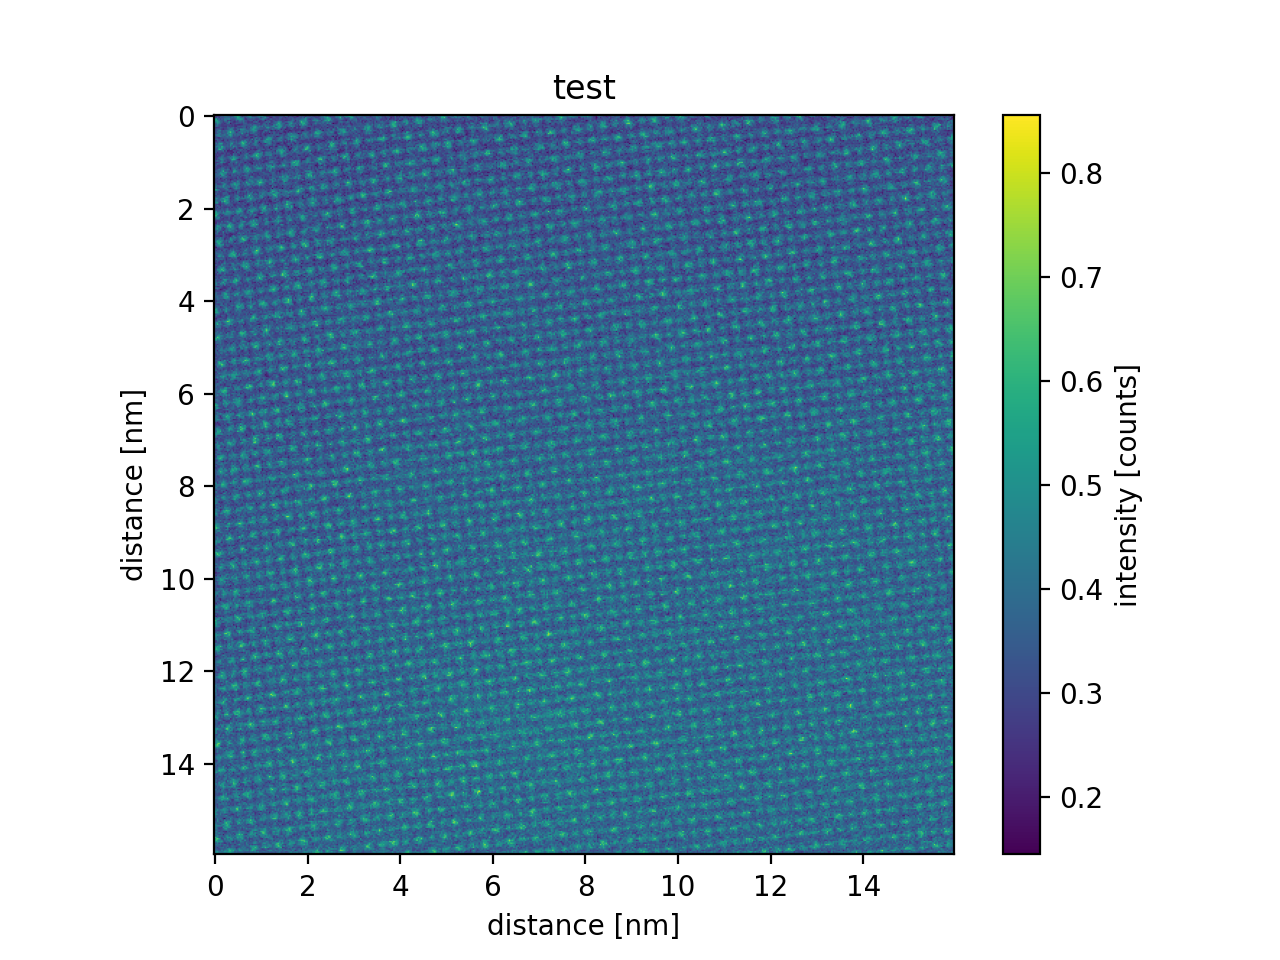

In [7]:
dset_list  =  nsid.io.hdf_utils.find_dataset(h5_file['Measurement_000/Channel_000'], 'nDim_Data')
data2 = nsid.NSIDask.from_hdf5(dset_list[0])

plot_image(data2)

### Accessing data from NSID and dask

In [8]:
dset = dset_list[0]

print(dset.parent['x'].attrs['dimension_type'])
print(data2.dim_1.dimension_type)
print(data2.x)
print(dset.dims[1].label)

spatial
spatial
x - distance (nm): [ 0.       0.03125  0.0625   0.09375  0.125    0.15625  0.1875   0.21875
  0.25     0.28125  0.3125   0.34375  0.375    0.40625  0.4375   0.46875
  0.5      0.53125  0.5625   0.59375  0.625    0.65625  0.6875   0.71875
  0.75     0.78125  0.8125   0.84375  0.875    0.90625  0.9375   0.96875
  1.       1.03125  1.0625   1.09375  1.125    1.15625  1.1875   1.21875
  1.25     1.28125  1.3125   1.34375  1.375    1.40625  1.4375   1.46875
  1.5      1.53125  1.5625   1.59375  1.625    1.65625  1.6875   1.71875
  1.75     1.78125  1.8125   1.84375  1.875    1.90625  1.9375   1.96875
  2.       2.03125  2.0625   2.09375  2.125    2.15625  2.1875   2.21875
  2.25     2.28125  2.3125   2.34375  2.375    2.40625  2.4375   2.46875
  2.5      2.53125  2.5625   2.59375  2.625    2.65625  2.6875   2.71875
  2.75     2.78125  2.8125   2.84375  2.875    2.90625  2.9375   2.96875
  3.       3.03125  3.0625   3.09375  3.125    3.15625  3.1875   3.21875
  3.25     3.281

And we close the file again.

In [9]:
h5_file.close()

In [10]:
import importlib
importlib.reload(ft)
data3 = ft.h5_open_file('test.hf5')

<IPython.core.display.Javascript object>


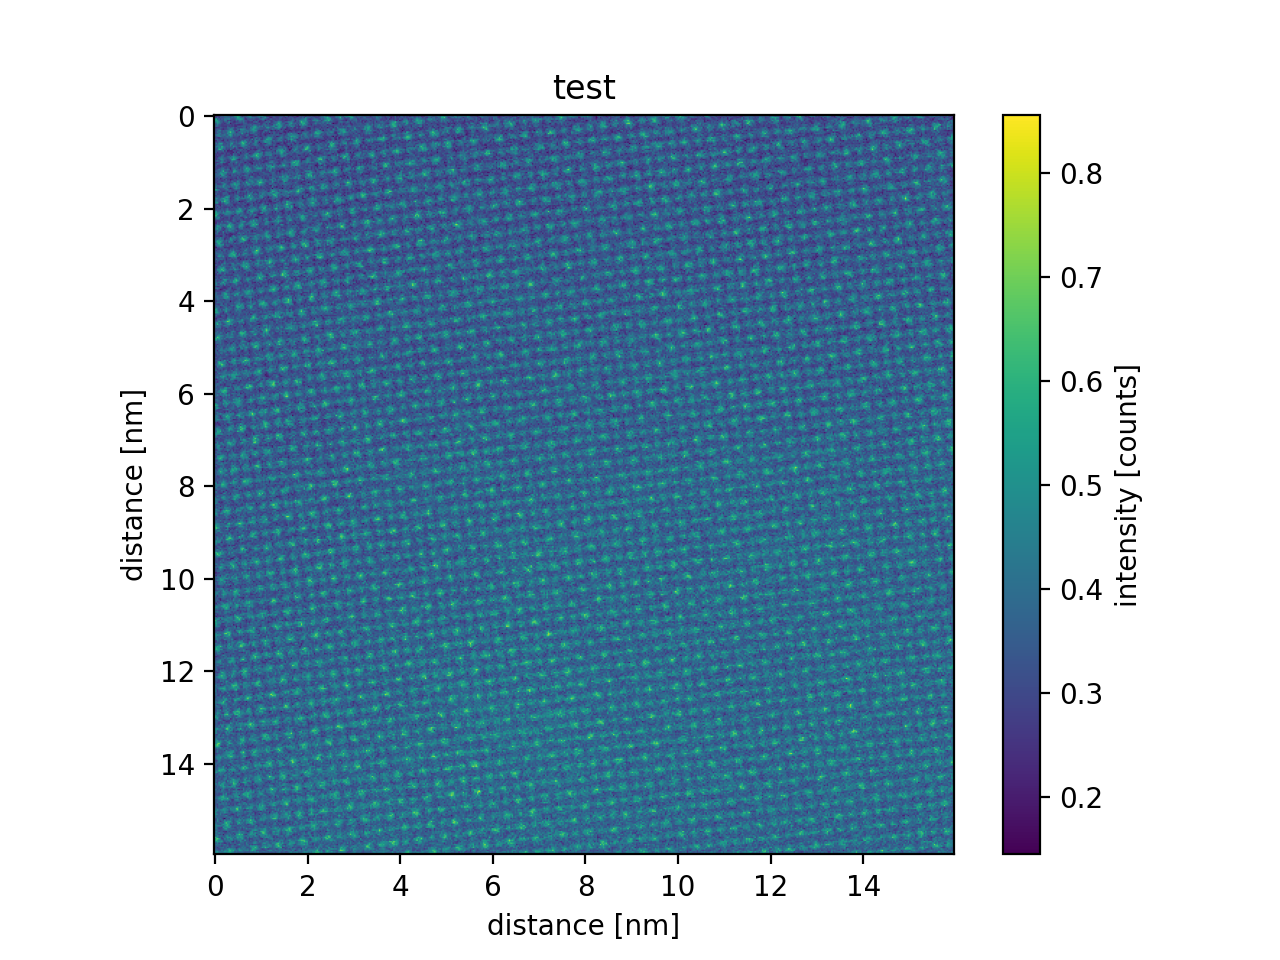

In [11]:
plot_image(data3)

In [14]:
print(data3.original_metadata)

{'category': 'persistent', 'collection_dimension_count': 0, 'created': '2020-03-23T14:30:58.738377', 'data_dtype': 'float32', 'data_modified': '2020-03-23T14:30:58.753998', 'data_shape': array([ 25, 512, 512]), 'datum_dimension_count': 2, 'dim-offset-0': 0.0, 'dim-offset-1': -8.0, 'dim-offset-2': -8.0, 'dim-scale-0': 1.0, 'dim-scale-1': 0.03125, 'dim-scale-2': 0.03125, 'dim-units-0': '', 'dim-units-1': 'nm', 'dim-units-2': 'nm', 'intensity_calibration.offset': 0.0, 'intensity_calibration.scale': 1.0, 'intensity_calibration.units': '', 'is_sequence': True, 'metadata.hardware_source.ImageScanned:BP1.^VOACurrent': 2.02867e-09, 'metadata.hardware_source.ImageScanned:C1 ConstW': 0.338, 'metadata.hardware_source.ImageScanned:C10': 7.627e-08, 'metadata.hardware_source.ImageScanned:C12.a': 5.53324e-09, 'metadata.hardware_source.ImageScanned:C12.b': 2.77692e-09, 'metadata.hardware_source.ImageScanned:C21.a': 5.23255e-08, 'metadata.hardware_source.ImageScanned:C21.b': -1.68525e-07, 'metadata.har